# A small sample demonstrating shadow mapping

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os

import matplotlib.pyplot as plt

ROOT_DIR = os.path.abspath('..')
sys.path.insert(0, ROOT_DIR)

import numpy as np

from OpenGL.GL import GL_DEPTH_ATTACHMENT

import pygl
from pygl import get_offscreen_context, spherical_harmonics
from pygl.framebuffer import FrameBuffer
from pygl import shader as shader_lib
from pygl.texture import get_default_texture_2d
from pygl.camera import orthographic
from pygl import transform

import OpenGL.GL as gl

from samples import scenes, utils

No EGL found!


In [2]:
ctx = get_offscreen_context()

SHADOW_SHAPE = (1024, 1024)

depth_map_fbo = FrameBuffer(SHADOW_SHAPE)
depth_texture = depth_map_fbo.attach_texture(GL_DEPTH_ATTACHMENT)
depth_map_fbo.detach_draw_buffer()
depth_map_fbo.detach_read_buffer()
print("Depthmap FBO created:")
print("\tDraw buffers are detached:", not depth_map_fbo._are_draw_buffers_attached)
print("\tRead buffer is detached:", not depth_map_fbo._is_read_buffer_attached)
print("\tComplete:", depth_map_fbo.is_complete)

scene = scenes.teapot_spiral()

default_fbo = FrameBuffer(scene.camera.screen_size)
color_tex = default_fbo.attach_texture(0)

shader = shader_lib.get_bling_phong_shader()
shadow_shader = shader_lib.get_shadow_map_shader()

illum = spherical_harmonics.default()

default_tex = get_default_texture_2d() 

Depthmap FBO created:
	Draw buffers are detached: True
	Read buffer is detached: True
	Complete: True


{GL_DEPTH_ATTACHMENT: <Texture2D: shape=(1024, 1024), format=<class 'numpy.float32'>, id=2>}


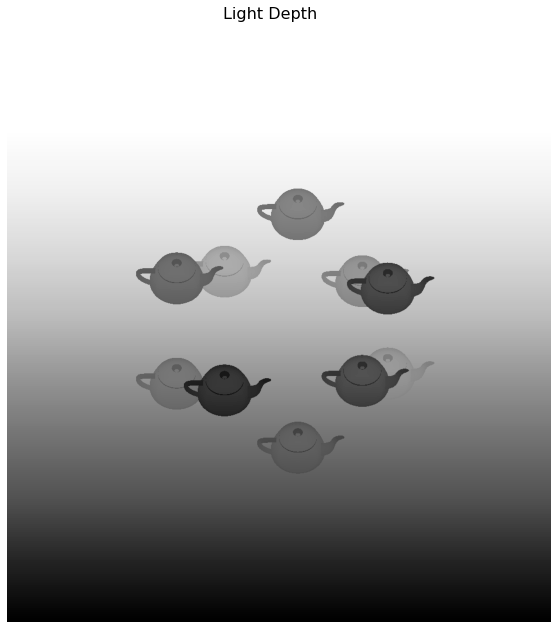

In [3]:
# Render the depth from the viewpoint of a directional light.
P = orthographic(-20, 20, -20, 20, 0.3, 50.0)
V = scene.camera.V @ transform.translate([0, 1, 0])
ls_VP = P@V

light_pos = np.linalg.inv(ls_VP)[:3, 3]

with depth_map_fbo:
    default_fbo.clear_color_attachment(0, (0.0, 0.0, 0.0, 1.0))
    default_fbo.clear_depth_buffer()
    ctx.culling = pygl.CullingMode.front
    for instance in scene.instances:
        scene.objects[instance.object].render(
            shadow_shader,
            mvp=(ls_VP@instance.ModelMatrix))
    ctx.culling = pygl.CullingMode.back

print(depth_map_fbo.attachments)
utils.display_images(depth_map_fbo, title="Light Depth", cmap='Greys_r')

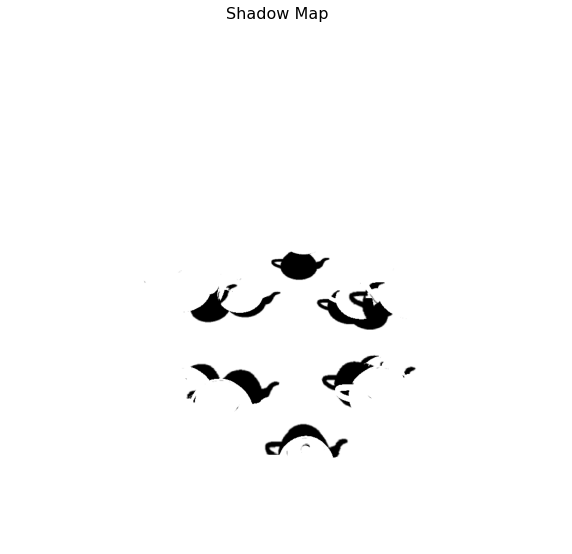

In [4]:
# A simple shader that renders the shadow values of the scene
shadow_vs = """#version 330 core
layout(location=0) in vec3 pos;
layout(location=2) in vec3 normal;

uniform mat4 mvp;
uniform mat4 normal_matrix;
uniform mat4 light_space_mvp;

out vec4 frag_pos;
out vec4 frag_normal;
out vec4 frag_light_space_pos;

void main() {
   frag_pos = mvp * vec4(pos, 1.0);
   frag_normal = normal_matrix * vec4(normal, 0.0);
   frag_light_space_pos = light_space_mvp * vec4(pos, 1.0);
   gl_Position = frag_pos;
}"""

shadow_fs  ="""#version 330 core
out vec4 FragColor;

in vec4 frag_pos;
in vec4 frag_normal;
in vec4 frag_light_space_pos;

uniform sampler2D shadow_map;
uniform vec3 light_pos;

float shadow_calculation() {
    // perform perspective divide
    vec3 projCoords = frag_light_space_pos.xyz / frag_light_space_pos.w;
    // transform to [0,1] range
    projCoords = projCoords * 0.5 + 0.5;
    // get closest depth value from light's perspective (using [0,1] range fragPosLight as coords)
    float closestDepth = texture(shadow_map, projCoords.xy).r; 
    // get depth of current fragment from light's perspective
    float currentDepth = projCoords.z;
    // calculate bias (based on depth map resolution and slope)
    vec3 normal = normalize(frag_normal.xyz);
    vec3 lightDir = normalize(light_pos.xyz - frag_pos.xyz);
    float bias = max(0.05 * (1.0 - dot(normal, lightDir)), 0.005);
    // check whether current frag pos is in shadow
    // float shadow = currentDepth - bias > closestDepth  ? 1.0 : 0.0;
    // PCF
    float shadow = 0.0;
    vec2 texelSize = 1.0 / textureSize(shadow_map, 0);
    for(int x = -1; x <= 1; ++x)
    {
        for(int y = -1; y <= 1; ++y)
        {
            float pcfDepth = texture(shadow_map, projCoords.xy + vec2(x, y) * texelSize).r; 
            shadow += currentDepth - bias > pcfDepth  ? 1.0 : 0.0;        
        }    
    }
    shadow /= 9.0;
    
    // keep the shadow at 0.0 when outside the far_plane region of the light's frustum.
    if(projCoords.z > 1.0)
        shadow = 0.0;
        
    return shadow;
}

void main() {
    float shadow = shadow_calculation();
    FragColor = vec4(vec3(1-shadow), 1.0);
}"""

display_shader = shader_lib.Shader(vertex=shadow_vs, fragment=shadow_fs)
ctx.culling = None
with default_fbo as fbo:
    fbo.clear_color_attachment(0, (0.0, 0.0, 0.0, 1.0))
    fbo.clear_depth_buffer()
    VP = scene.camera.VP
    ls_VP = P@V
    for instance in scene.instances:
        MVP = VP @ instance.ModelMatrix
        normal_matrix = scene.camera.V @ np.linalg.inv(instance.ModelMatrix).T
        ls_MVP = ls_VP @ instance.ModelMatrix
        scene.objects[instance.object].render(
            display_shader,
            mvp=MVP,
            light_space_mvp=ls_MVP,
            normal_matrix=normal_matrix,
            shadow_map=depth_texture,
            light_pos=light_pos)

utils.display_images(default_fbo, title="Shadow Map")

# Shadow Mapping for Point Lights

In [5]:
point_light_vs = """#version 330 core
layout (location = 0) in vec3 aPos;

uniform mat4 model;
uniform mat4 shadowMatrix;

out vec4 FragPos;

void main()
{
    FragPos = model * vec4(aPos, 1.0);
    gl_Position = shadowMatrix * FragPos;
}"""

point_light_fs = """#version 330 core
in vec4 FragPos;

uniform vec3 lightPos;
uniform float far_plane;

void main()
{
    float lightDistance = length(FragPos.xyz - lightPos);
    
    // map to [0;1] range by dividing by far_plane
    lightDistance = lightDistance / far_plane;
    
    // write this as modified depth
    gl_FragDepth = lightDistance;
}"""

point_light_shadowmap_shader = shader_lib.Shader(vs=point_light_vs, 
                                                 fs=point_light_fs)

Render the shadow map

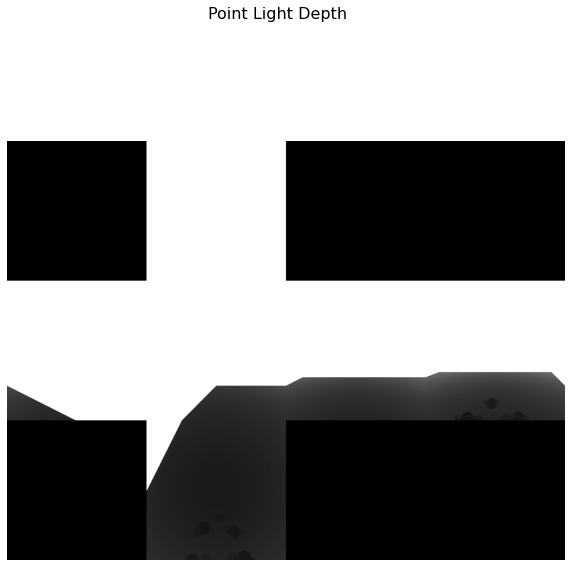

In [6]:
from pygl.camera import perspective
from pygl import transform
from pygl.texture import CubeMap, tfilter, tformat, ttype
from pygl.framebuffer import FrameBuffer

shadow_map_fbo = FrameBuffer(SHADOW_SHAPE)
pl_shadow_tex = CubeMap(SHADOW_SHAPE, 
                        tformat=tformat.depth, 
                        tp=ttype.float32,
                        tfilter=tfilter.nearest)

near = scene.camera.near
far  = scene.camera.far

light_pos = scene.camera.M.dot(np.array([0, 8, 0, 1]))[:3].astype(np.float32)

shadowP = perspective(np.radians(90.0), SHADOW_SHAPE[1] / SHADOW_SHAPE[0], near, far)
shadow_transforms = np.asanyarray([np.dot(shadowP, V) for V in CubeMap.get_capture_views(light_pos)])

with shadow_map_fbo as fbo:
    for i, shadowVP in enumerate(shadow_transforms):
        fbo.attach_texture(gl.GL_DEPTH_ATTACHMENT, 
                                    pl_shadow_tex, 
                                    texture_target=gl.GL_TEXTURE_CUBE_MAP_POSITIVE_X + i)
        fbo.clear_depth_buffer()

        for instance in scene.instances:
            scene.objects[instance.object].render(
                point_light_shadowmap_shader,
                model=instance.ModelMatrix,
                shadowMatrix=shadowVP,
                far_plane=far,
                lightPos=light_pos)

shadow_map = pl_shadow_tex.download()
utils.display_images(shadow_map, title="Point Light Depth", cmap='gray')

## Shading using the shadow map

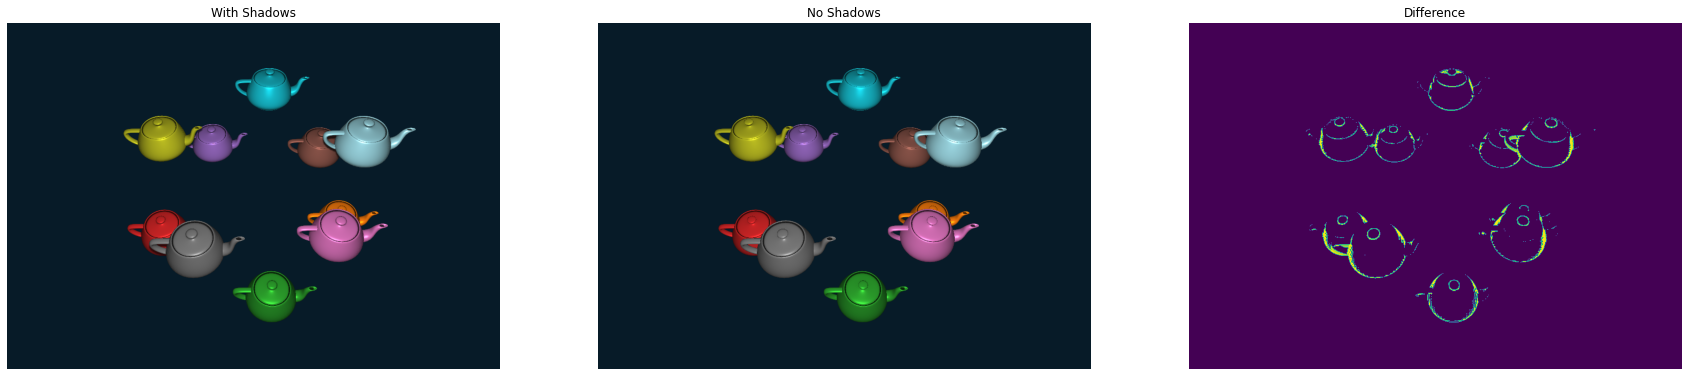

In [42]:
vs = """#version 330 core
layout (location = 0) in vec3 aPos;
layout (location = 2) in vec3 aNormal;

out VS_OUT {
    vec3 FragPos;
    vec3 Normal;
} vs_out;

uniform mat4 projection;
uniform mat4 view;
uniform mat4 model;

void main()
{
    vs_out.FragPos = vec3(model * vec4(aPos, 1.0));
    vs_out.Normal = transpose(inverse(mat3(model))) * aNormal;
    gl_Position = projection * view * model * vec4(aPos, 1.0);
}"""

fs = """#version 330 core
out vec4 FragColor;

in VS_OUT {
    vec3 FragPos;
    vec3 Normal;
} fs_in;

uniform samplerCube depthMap;

uniform vec3 lightPos;
uniform vec3 viewPos;
uniform vec4 kd;
uniform vec3 lightColor;

uniform float far_plane;
uniform bool shadows;


// array of offset direction for sampling
vec3 gridSamplingDisk[20] = vec3[]
(
   vec3(1, 1,  1), vec3( 1, -1,  1), vec3(-1, -1,  1), vec3(-1, 1,  1), 
   vec3(1, 1, -1), vec3( 1, -1, -1), vec3(-1, -1, -1), vec3(-1, 1, -1),
   vec3(1, 1,  0), vec3( 1, -1,  0), vec3(-1, -1,  0), vec3(-1, 1,  0),
   vec3(1, 0,  1), vec3(-1,  0,  1), vec3( 1,  0, -1), vec3(-1, 0, -1),
   vec3(0, 1,  1), vec3( 0, -1,  1), vec3( 0, -1, -1), vec3( 0, 1, -1)
);

float ShadowCalculation(vec3 fragPos)
{
    // get vector between fragment position and light position
    vec3 fragToLight = fragPos - lightPos;
    // use the fragment to light vector to sample from the depth map    
    // float closestDepth = texture(depthMap, fragToLight).r;
    // it is currently in linear range between [0,1], let's re-transform it back to original depth value
    // closestDepth *= far_plane;
    // now get current linear depth as the length between the fragment and light position
    float currentDepth = length(fragToLight);
    // test for shadows
    float shadow = 0.0;
    float bias = 0.15;
    int samples = 20;
    float viewDistance = length(viewPos - fragPos);
    float diskRadius = (1.0 + (viewDistance / far_plane)) / 25.0;
    for(int i = 0; i < samples; ++i)
    {
        float closestDepth = texture(depthMap, fragToLight + gridSamplingDisk[i] * diskRadius).r;
        closestDepth *= far_plane;   // undo mapping [0;1]
        if(currentDepth - bias > closestDepth)
            shadow += 1.0;
    }
    shadow /= float(samples);
        
    return shadow;
}

void main()
{           
    vec3 color = kd.rgb;
    vec3 normal = normalize(fs_in.Normal);
    // ambient
    vec3 ambient = 0.3 * lightColor;
    // diffuse
    vec3 lightDir = normalize(lightPos - fs_in.FragPos);
    float diff = max(dot(lightDir, normal), 0.0);
    vec3 diffuse = diff * lightColor;
    // specular
    vec3 viewDir = normalize(viewPos - fs_in.FragPos);
    vec3 reflectDir = reflect(-lightDir, normal);
    float spec = 0.0;
    vec3 halfwayDir = normalize(lightDir + viewDir);  
    spec = pow(max(dot(normal, halfwayDir), 0.0), 64.0);
    vec3 specular = spec * lightColor;    
    // calculate shadow
    float shadow = shadows ? ShadowCalculation(fs_in.FragPos) : 0.0;                      
    vec3 lighting = (ambient + (1.0 - shadow) * (diffuse + specular)) * color;    
    
    FragColor = vec4(lighting, 1.0);
}"""

shader = shader_lib.Shader(vs=vs, fs=fs)
VP = scene.camera.VP
colors = plt.get_cmap('tab20')(np.linspace(0, 1, len(scene.instances)))
light_color = np.array([.75, .75, .75], dtype=np.float32)

with default_fbo as fbo:
    fbo.clear_color_attachment(0, (.3, .3, .3, 1))
    fbo.clear_depth_buffer()
    for instance, color in zip(scene.instances, colors):
        scene.objects[instance.object].render(
            shader,
            projection=scene.camera.P,
            view=scene.camera.V,
            model=instance.ModelMatrix,
            depthMap=pl_shadow_tex,
            lightPos=light_pos[:3],
            viewPos=scene.camera.position[:3],
            kd=color.astype(np.float32),
            far_plane=far,
            lightColor=light_color,
            shadows=1)
    with_shadows = color_tex.download(True)

    fbo.clear_color_attachment(0, (.3, .3, .3, 1))
    fbo.clear_depth_buffer()
    for instance, color in zip(scene.instances, colors):
        scene.objects[instance.object].render(
            shader,
            model=instance.ModelMatrix,
            kd=color.astype(np.float32),
            shadows=0)
    no_shadows = color_tex.download(True)


utils.display_images([with_shadows, no_shadows, np.linalg.norm(with_shadows  - no_shadows, axis=-1)], titles=['With Shadows', 'No Shadows', "Difference"])